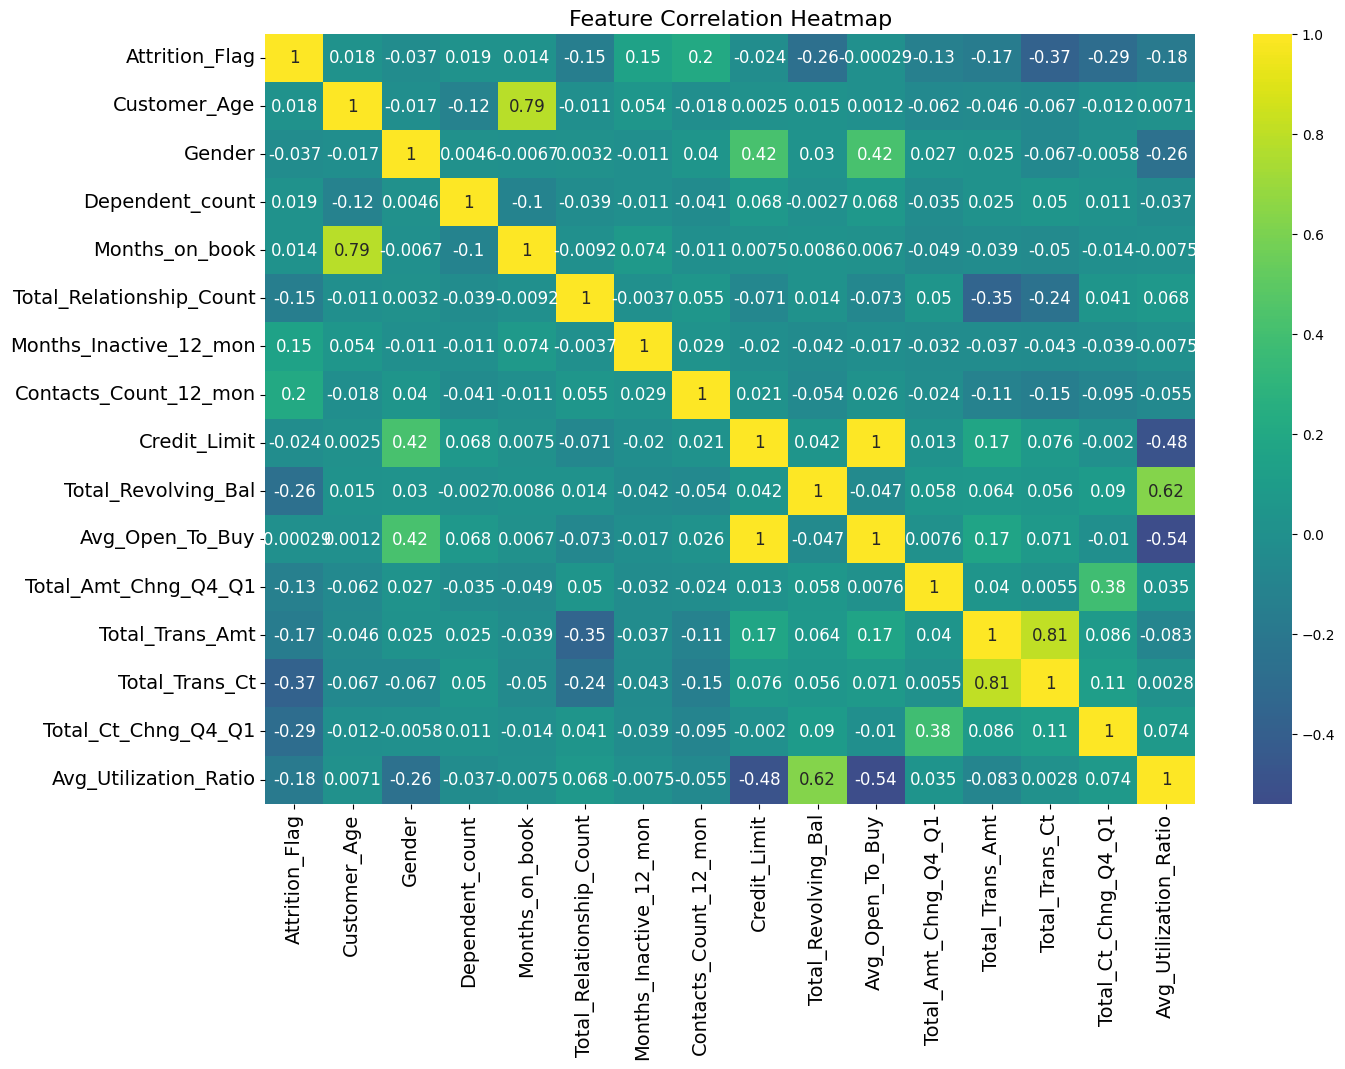

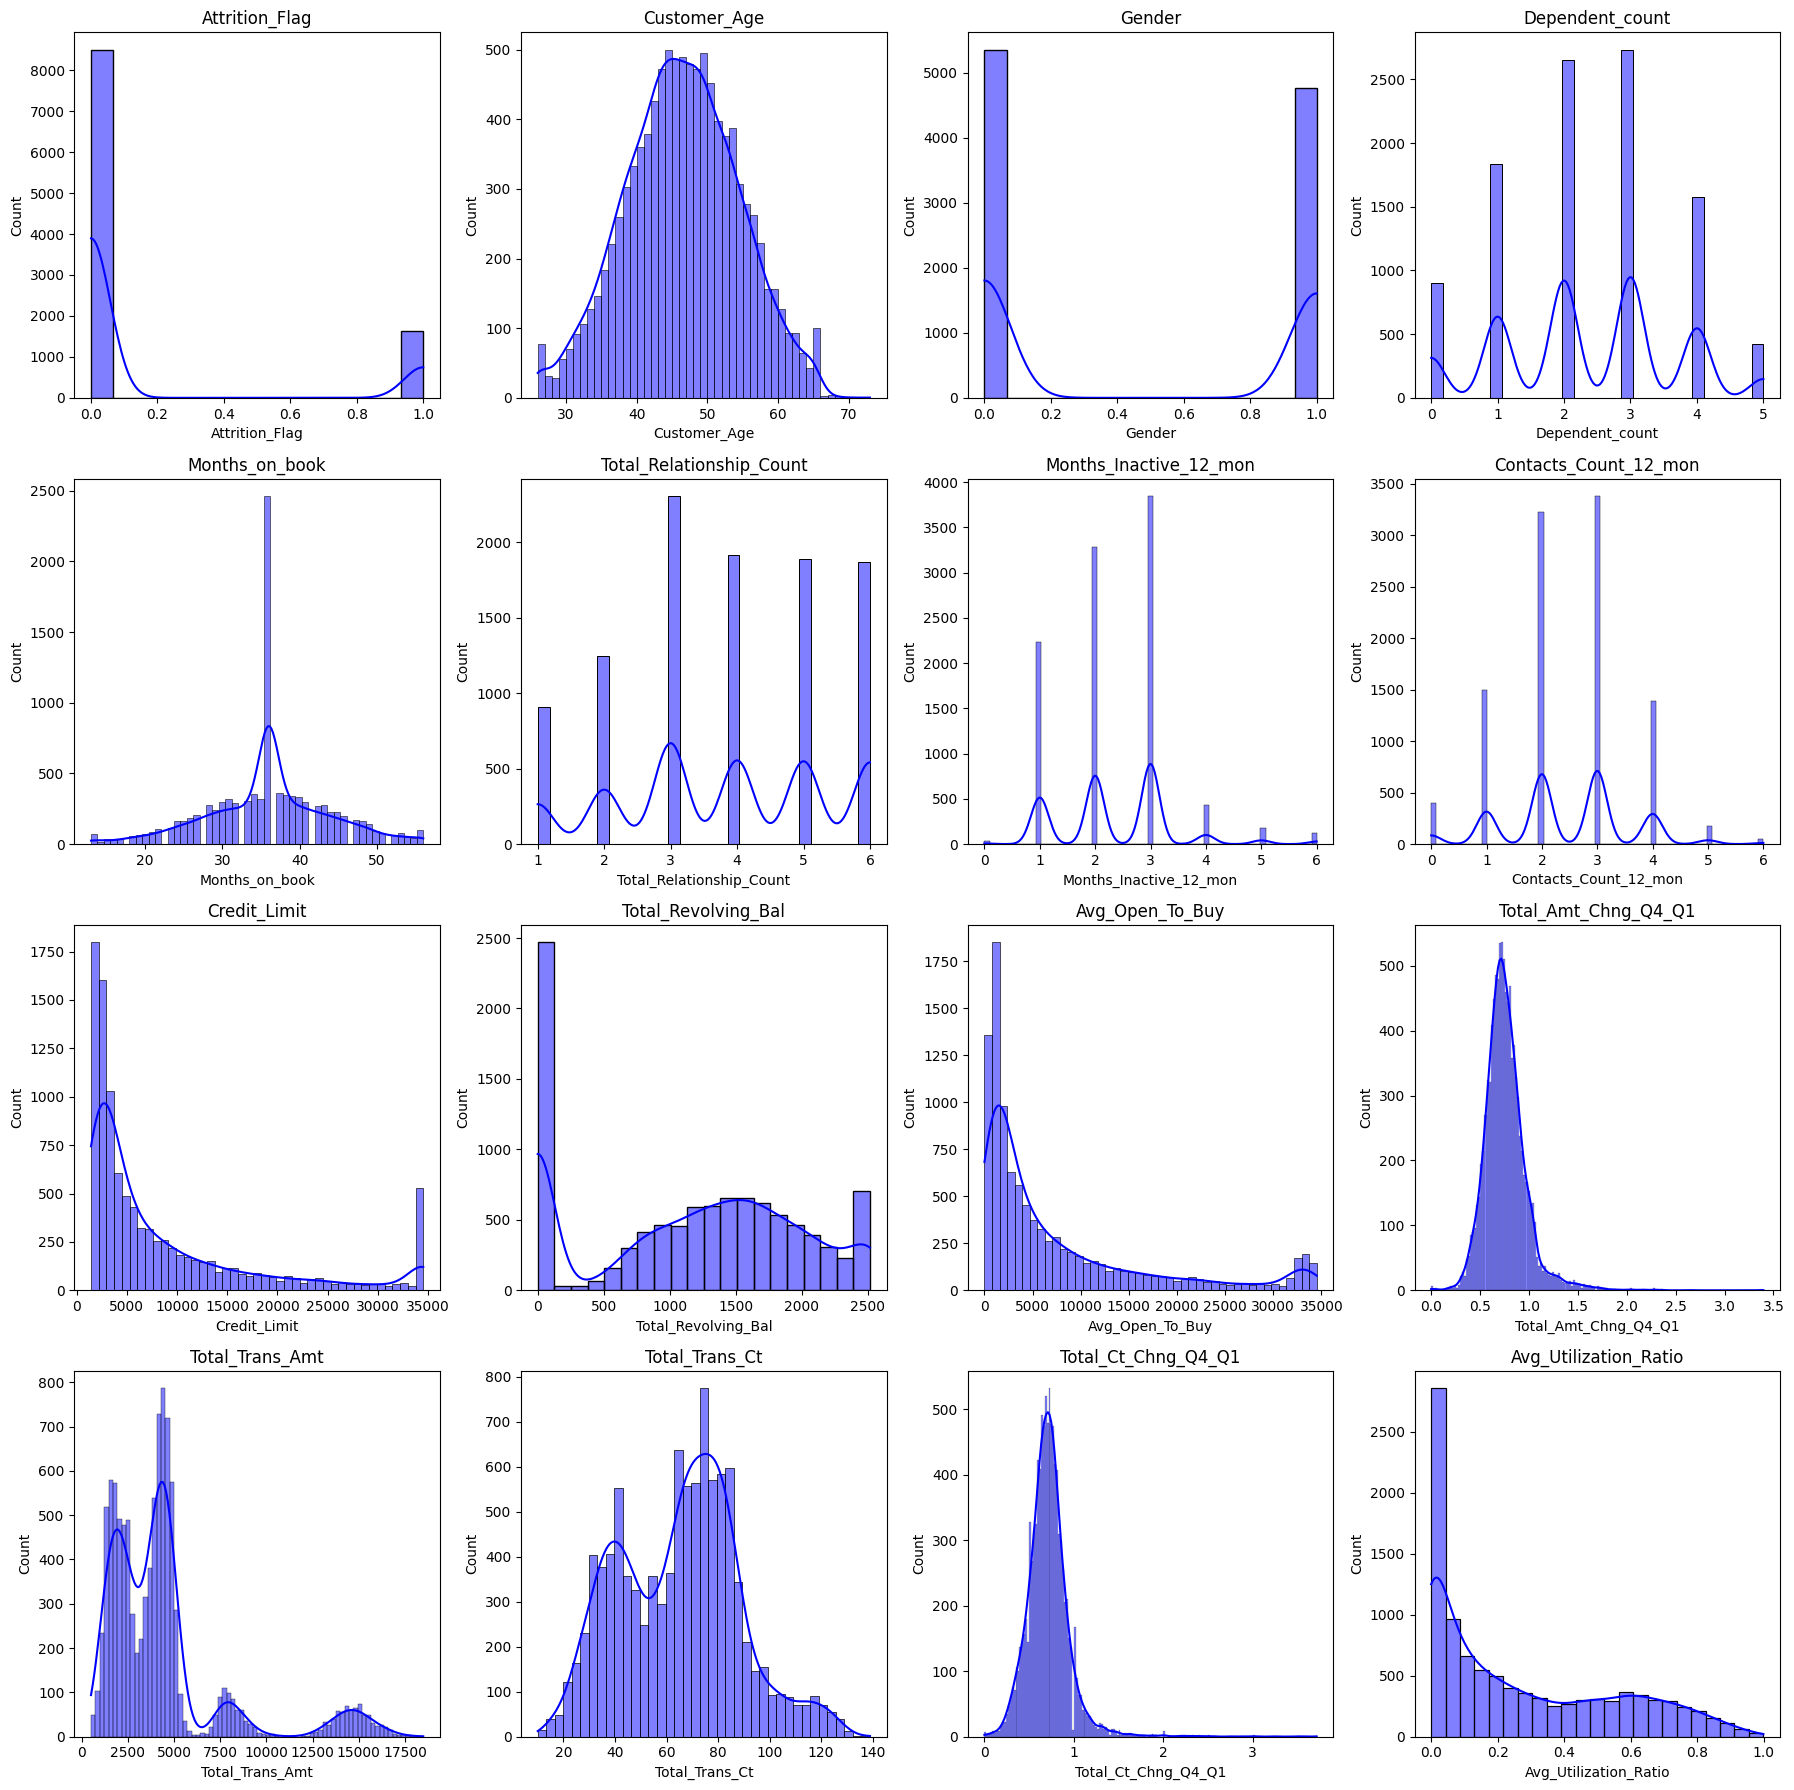

c:\Users\munta\OneDrive\Desktop\The Projects\DA_projects-credit-card-churn\muntadher\.venv\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\munta\OneDrive\Desktop\The Projects\DA_projects-credit-card-churn\muntadher\.venv\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Model: Logistic Regression
Accuracy: 0.84
F1-Score: 0.86
Cross-Val Accuracy: 0.85 (+/- 0.01)
              precision    recall  f1-score   support

           0       0.95      0.86      0.90      2125
           1       0.51      0.79      0.62       407

    accuracy                           0.84      2532
   macro avg       0.73      0.82      0.76      2532
weighted avg       0.88      0.84      0.86      2532

--------------------------------------------------
Model: Decision Tree
Accuracy: 0.94
F1-Score: 0.94
Cross-Val Accuracy: 0.96 (+/- 0.01)
              precision    recall  f1-score   support

           0       0.97      0.96      0.96      2125
           1       0.79      0.86      0.82       407

    accuracy                           0.94      2532
   macro avg       0.88      0.91      0.89      2532
weighted avg       0.94      0.94      0.94      2532

--------------------------------------------------
Model: KNN
Accuracy: 0.88
F1-Score: 0.89
Cross-Val Accuracy: 0.9

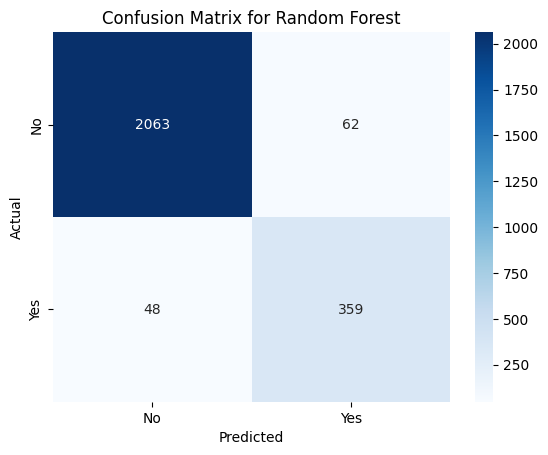

C:\Users\munta\AppData\Local\Temp\ipykernel_1864\4138866041.py:116: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_importances, y=sorted_columns, palette='viridis')


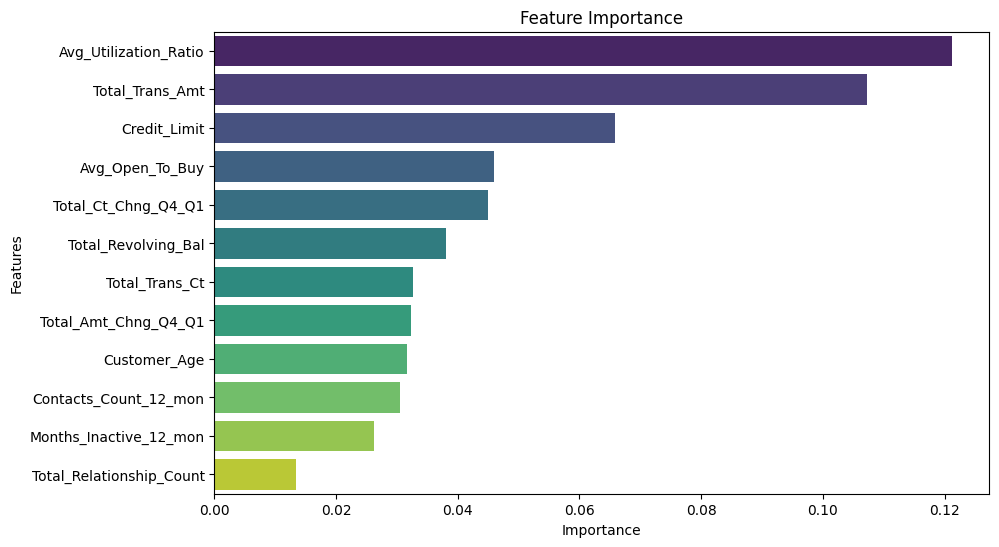

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# Load data
data = pd.read_csv('../cleaned_data/cleaned_data.csv')

# Exploratory Data Analysis
# Correlation heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(data.select_dtypes(include=['int', 'float']).corr(), annot=True, center=0, cmap='viridis', annot_kws={'size': 12})
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title("Feature Correlation Heatmap", fontsize=16)
plt.show()

# Histograms for continuous features
plt.figure(figsize=(18, 18))
for i, col in enumerate(data.select_dtypes(include=['int', 'float']).columns):
    ax = plt.subplot(4, 4, i + 1)
    sns.histplot(data=data, x=col, kde=True, ax=ax, color='blue')
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    ax.set_title(col, fontsize=12)
plt.tight_layout()
plt.show()

# One-Hot Encoding for categorical features
categorical_cols = ['Education_Level', 'Income_Category', 'Marital_Status', 'Card_Category']
data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

# Split features and target variable
X = data.drop(columns='Attrition_Flag')
y = data['Attrition_Flag']

# Feature Selection using ExtraTreesClassifier
clf = ExtraTreesClassifier(n_estimators=100, random_state=42)
clf.fit(X, y)
feature_importances = clf.feature_importances_
selected_features = X.columns[feature_importances > np.mean(feature_importances)]
X = X[selected_features]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)

# Handle class imbalance using SMOTE
sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)

# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train and evaluate models
models = [
    ('Logistic Regression', LogisticRegression()),
    ('Decision Tree', DecisionTreeClassifier(criterion='entropy', random_state=42)),
    ('KNN', KNeighborsClassifier(n_neighbors=5)),
    ('Naive Bayes', GaussianNB()),
    ('Random Forest', RandomForestClassifier(n_estimators=100, random_state=42))
]

model_comparison = {}

for model_name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    model_comparison[model_name] = {
        'Accuracy': accuracy,
        'F1-Score': f1,
        'CV Accuracy': cv_scores.mean(),
        'CV Std': cv_scores.std()
    }
    print(f"Model: {model_name}")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"F1-Score: {f1:.2f}")
    print(f"Cross-Val Accuracy: {cv_scores.mean():.2f} (+/- {cv_scores.std():.2f})")
    print(classification_report(y_test, y_pred))
    print("-" * 50)

# Confusion Matrix for the best-performing model
best_model_name = max(model_comparison, key=lambda x: model_comparison[x]['F1-Score'])
best_model = [model for model in models if model[0] == best_model_name][0][1]
y_pred = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.title(f"Confusion Matrix for {best_model_name}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


# Feature Importance Plot
# Get the feature importances aligned with selected features
selected_features = X.columns  # This contains only the features selected by feature selection
sorted_idx = np.argsort(feature_importances[:len(selected_features)])[::-1]  # Limit feature_importances to selected features
sorted_columns = selected_features[sorted_idx]  # Sort selected features
sorted_importances = feature_importances[:len(selected_features)][sorted_idx]  # Sort importances

# Plot sorted feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x=sorted_importances, y=sorted_columns, palette='viridis')
plt.title("Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()

